In [1]:
import librosa
import os
import soundfile as sf
import time
import librosa.display
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import cv2
import sounddevice as sd
from PIL import Image

In [2]:
OUTPUT_DIR = './'
INPUT_DIR = './data/'

In [3]:
def get_wav_info(wav_file):
    frames, sr = librosa.load(wav_file)
    #duration ==> nbr-frames / sample_rate
    return frames, sr

get_wav_info

<function __main__.get_wav_info(wav_file)>

In [4]:
path = './data'
def wave_to_spectrogram(gender):
    if not os.path.exists(os.path.join(OUTPUT_DIR, 'audio-images')):
        os.mkdir(os.path.join(OUTPUT_DIR, 'audio-images'))
    for file in tqdm(os.listdir("./data/"+gender)):
        if "wav" in file:
            file_path = os.path.join(path + f'/{gender}', file)
            file_stem = Path(file_path).stem
            dist_dir = OUTPUT_DIR + 'audio-images' + f'/{gender}'
            file_dist_path = os.path.join(dist_dir, file_stem)  
            if not os.path.exists(file_dist_path + '.png'):
                if not os.path.exists(dist_dir):
                    os.mkdir(dist_dir)
                frames, sr = get_wav_info(file_path)
                S = librosa.feature.melspectrogram(y = frames, sr = sr)
                S_db = librosa.amplitude_to_db(S, ref = np.max)
                plt.figure(figsize=(1.9, 1.9))
                librosa.display.specshow(S_db,cmap='viridis', sr = sr)
                plt.axis('off')
                plt.tight_layout()
                plt.savefig(f'{file_dist_path}.png', bbox_inches='tight', pad_inches=0)
                plt.close()
    return None

In [140]:
wave_to_spectrogram("male")

100%|████████████████████████████████████████| 6001/6001 [07:38<00:00, 13.09it/s]


In [141]:
wave_to_spectrogram("female")

100%|████████████████████████████████████████| 6001/6001 [06:57<00:00, 14.38it/s]


In [5]:
image_directory = './audio-images/'
SIZE = 160
dataset = []
label = []

In [6]:
male_audio_spectrogram = os.listdir(image_directory + 'male/')
for i, image_name in enumerate(male_audio_spectrogram):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'male/' + image_name)
        image = Image.fromarray(image, 'RGB')
        dataset.append(np.array(image))
        label.append(1)

In [7]:
female_audio_spectrogram = os.listdir(image_directory + 'female/')
for i, image_name in enumerate(female_audio_spectrogram):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'female/' + image_name)
        image = Image.fromarray(image, 'RGB')
        dataset.append(np.array(image))
        label.append(0)

In [8]:
dataset = np.array(dataset)
label = np.array(label)

In [9]:
from sklearn.model_selection import train_test_split
from keras.utils import normalize


X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)

X_train = normalize(X_train, axis=1)
X_test = normalize(X_test, axis=1)

2023-03-21 17:21:40.850599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense

INPUT_SHAPE = (SIZE, SIZE, 3)   #change to (SIZE, SIZE, 3)


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))  

2023-03-21 17:22:53.921388: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',             
              metrics=['accuracy'])

print(model.summary())    


history = model.fit(X_train, 
                         y_train, 
                         batch_size = 16, 
                         verbose = 1, 
                         epochs = 20,      
                         validation_data=(X_test,y_test),
                         shuffle = False
                     )


model.save('voice_model_20epochs.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 32)      896       
                                                                 
 activation (Activation)     (None, 158, 158, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 77, 77, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                    

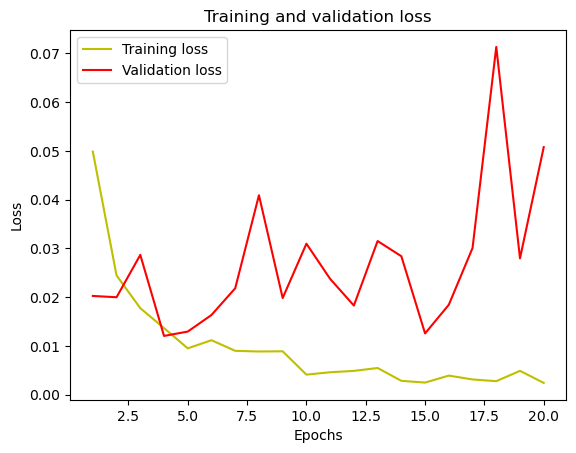

In [13]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

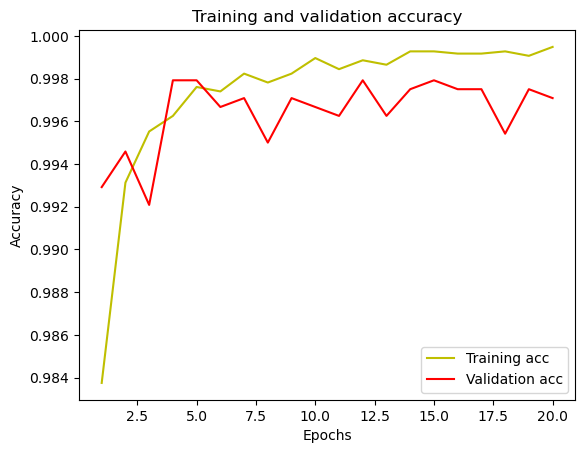

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [18]:
def record_and_save_spectrogram():
    if not os.path.exists(os.path.join(OUTPUT_DIR, 'audio-images-recorded')):
        os.mkdir(os.path.join(OUTPUT_DIR, 'audio-images-recorded'))
    sr = 22050
    # Record 1 second of audio
    try:
        frames = sd.rec(int(22050 * 1), samplerate=22050, channels=1, blocking=True)
    except Exception as e:
        print(f'Error recording audio: {e}')
        return

    # Convert audio to spectrogram
    S = librosa.feature.melspectrogram(y=frames[:, 0], sr=sr)
    S_db = librosa.amplitude_to_db(S, ref=np.max)

    # Save spectrogram as PNG
    timestamp = time.strftime("%Y-%m-%d-%H:%M:%S")
    file_path = os.path.join(OUTPUT_DIR, 'audio-images-recorded', f'spectrogram_{timestamp}.png')
    plt.figure(figsize=(1.9, 1.9))
    librosa.display.specshow(S_db, cmap='viridis', sr=sr)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    print(f'Spectrogram saved to {file_path}')
    return file_path



In [5]:
record_and_save_spectrogram()

NameError: name 'OUTPUT_DIR' is not defined

In [1]:
h = []
myrec = cv2.imread(record_and_save_spectrogram())
myrec = Image.fromarray(myrec, 'RGB')
h.append(np.array(myrec))

h = np.array(h)
h = normalize(h, axis=1)

img = h[0]

plt.imshow(img)

input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
per = model.predict(input_img)
print("The prediction for this image is: ", per)
if per >= 0.9:
    print("You are SIGMA MALE")
elif per < 0.9 and per > 0.5:
    print("You are MALE")
else:
    print("You are FEMALE")

NameError: name 'cv2' is not defined